# 0. Install and Import Dependencies

In [34]:
# !pip list

In [35]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [36]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [37]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [38]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [39]:
# from google.colab import drive
import zipfile
import numpy as np
import pandas as pd

In [40]:
alignment_path = 'data/alignments/s1'
S1_path = 'data/s1'

# Get a list of the files in each folder
alignment_files = sorted(os.listdir(alignment_path))
video_files = sorted(os.listdir(S1_path))
video_files.remove('Thumbs.db')
length=len(alignment_files)
data={"video":[],"alignment":[]}
for i in range(length):
    data["video"].append(video_files[i])
    data["alignment"].append(alignment_files[i])
df=pd.DataFrame(data)
df=df[df["video"]!="sgib8n.mpg"] #remove videos with damaged frames 
df=df.sample(frac=1).reset_index(drop=True)
mini_data=df.loc[:500]

In [41]:
mini_data

,video,alignment
0,bris4p.mpg,bris4p.align
1,sgwj7a.mpg,sgwj7a.align
2,brwt7a.mpg,brwt7a.align
3,lrik2n.mpg,lrik2n.align
4,prwk1a.mpg,prwk1a.align
...,...,...
496,swih8p.mpg,swih8p.align
497,pbbj1a.mpg,pbbj1a.align
498,prbx3s.mpg,prbx3s.align
499,bbil5a.mpg,bbil5a.align


In [42]:
def draw_boundaries(img, classifier, scaleFactor, minNeighbors, color, text):
    # Converting image to gray-scale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # detecting features in gray-scale image, returns coordinates, width and height of features
    features = classifier.detectMultiScale(gray_img, scaleFactor, minNeighbors)
    coords = []
    # drawing rectangle around the feature and labeling it
    for (x, y, w, h) in features:
        cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
        cv2.putText(img, text, (x, y-4), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 1, cv2.LINE_AA)
        coords = [x, y, w, h]
    return coords

In [43]:
def detect(img, faceCascade,mouthCascade):
    color = {"blue":(255,0,0), "red":(0,0,255), "green":(0,255,0), "white":(255,255,255)}
    coords = draw_boundaries(img, faceCascade, 1.1, 10, color['green'], "face")
    #to detect the mouth inside the ROI area we put it here instead of under the "if" condition
    # If feature is detected, the draw_boundary method will return the x,y coordinates and width and height of rectangle else the length of coords will be 0
    if len(coords)==4:

                # Updating region of interest by cropping image lower half of the face
        ROI = img[int(coords[1] + coords[3] * 0.6):int(coords[1] + coords[3] * 0.9), int(coords[0]):int(coords[0] +coords[2])]


        return ROI  #return lower half of the face

    return img

In [44]:
def load_video(path:str) -> List[float]: 
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
    mouthCascade = cv2.CascadeClassifier('Mouth.xml') 
    
    cap = cv2.VideoCapture(path)
    frames = []

    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        if not ret:
            break

        mouth = detect(frame, faceCascade,mouthCascade)
        mouth_size=(140,40)
        img=cv2.resize(mouth, mouth_size)

        frame = tf.image.rgb_to_grayscale(img)
        

        frames.append(frame)
        
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [45]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [46]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [47]:
len(char_to_num.get_vocabulary())

40

In [48]:
char_to_num("nick")

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [49]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [50]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    # file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [51]:
test_path = 'bbal6n.mpg'

In [52]:

path='bbal6n.mpg'
file_name = path.split('.')[0]

In [53]:
file_name

'bbal6n'

In [54]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [55]:
frames, alignments = load_data(tf.convert_to_tensor(test_path)) #dataset object has its elements as tensor

In [57]:
len(alignments)

21

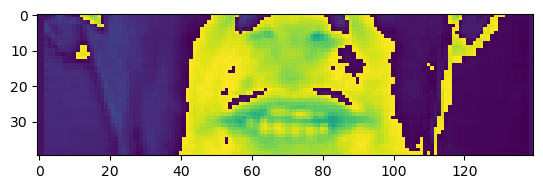

In [58]:
plt.imshow(frames[40])

In [59]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [60]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]).numpy().decode('utf-8')

'bin blue at l six now'

In [61]:
def preprocess_data(path:str) ->List[str]:
                                               #frames     #alignments
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [62]:
from matplotlib import pyplot as plt

In [63]:
# data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = tf.data.Dataset.from_tensor_slices((list(mini_data["video"])))
data = data.shuffle(11, reshuffle_each_iteration=False)

# Split data into training and testing
num_train = int(0.8 * 500)
num_test = 500 - num_train
train_data = data.take(num_train)
test_data = data.skip(num_train)

train_data = train_data.map(preprocess_data)
train_data = train_data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) #returns 3videos and 3 alignments
train_data = train_data.prefetch(tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_data)
test_data = test_data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [64]:
len(train_data)

200

In [65]:
# Get the number of samples in the train data
train_size = train_data.cardinality().numpy()
print(f"Number of padded batches in train data: {train_size}")

# Get the number of samples in the test data
test_size = test_data.cardinality().numpy()
print(f"Number of padded batches in test data: {test_size}")

Number of padded batches in train data: 200
Number of padded batches in test data: 51


In [66]:

                                #pointer 
                                #iterates over 
                                #padded batch   #vids/alignments  #video/align num in batch
len(train_data.as_numpy_iterator().next()         [1]              [1])

40

In [67]:
frames, alignments = train_data.as_numpy_iterator().next()

In [68]:
len(alignments)

2

# 3. Design the Deep Neural Network

In [69]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [70]:
INPUT_SHAPE=(75,40,140,1)

In [107]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,40,140,1), padding='same',name="conv1"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same',name="conv2"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3, padding='same',name="conv3"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten(),name="time_distributed"))

model.add(Bidirectional(LSTM(128, return_sequences=True),name="bi_lstm1"))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, return_sequences=True),name="bi_lstm2"))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax',name="final_dense"))

In [108]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x793e6a90b250>>

In [76]:
sample = test_data.as_numpy_iterator()

In [77]:
type(sample)

tensorflow.python.data.ops.dataset_ops._NumpyIterator

In [78]:
len(test_data)

51

In [79]:
val = sample.next(); #contains a batch

type(val[0])

numpy.ndarray

In [80]:
val[0][0].shape

(75, 40, 140, 1)

In [81]:
val[0].shape

(2, 75, 40, 140, 1)

In [84]:
yhat = model2.predict(val[0])

1/1 [==============================] - 9s 9s/step


In [85]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white at l four please'>

In [86]:
tf.argmax(yhat[1],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 25, 25])>

In [87]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'2222222yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy'>

In [88]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'2222222yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy'>

# 4. Setup Training Options and Train

In [94]:
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [95]:
#credit : https://keras.io/examples/audio/ctc_asr/#model

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [96]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [110]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=CTCLoss)

In [111]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [112]:
schedule_callback = LearningRateScheduler(scheduler)

In [113]:
example_callback = ProduceExample(train_data)

In [117]:
model.fit(train_data, epochs=50, callbacks=[checkpoint_callback, schedule_callback,example_callback])

Epoch 1/8
1/1 [==============================] - 3s 3s/steps - loss: 88.01
Original: set blue at t eight please
Prediction:  e e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white in x one soon
Prediction:  e e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
200/200 [==============================] - 1275s 6s/step - loss: 88.0163 - lr: 0.0010
Epoch 2/8
1/1 [==============================] - 0s 240ms/step loss: 73.14
Original: place green with z one again
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue by c four now
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
200/200 [==============================] - 1259s 6s/step - loss: 73.1486 - lr: 0.0010
Epoch 3/8
1/1 [============

In [118]:
import joblib  # For saving model
model.save('model.joblib')

In [ ]:
model.save('my_model.h5')


# 5. Make a Prediction 

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [ ]:
# model.load_weights('models/checkpoint')

In [119]:
test_data = test_data.as_numpy_iterator()

In [120]:
sample = test_data.next()

In [121]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 287ms/step


In [122]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin white at a two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white at l four please'>]

In [123]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [124]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'la re e ao'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'la re e ao'>]